### Data Collection

In [1]:
import pandas as pd

# 1) Load
df = pd.read_csv("airlines_reviews.csv")

# 2) Keep only the two airlines
brands = ["Turkish Airlines", "Qatar Airways"]
df = df[df["Airline"].isin(brands)].copy()

In [2]:
# Basic dataset info
print("Dataset shape:", df.shape)

# Check missing values in key columns
df[["Reviews", "Airline", "Recommended", "Overall Rating", "Review Date"]].isnull().sum()


Dataset shape: (3309, 17)


Reviews           0
Airline           0
Recommended       0
Overall Rating    0
Review Date       0
dtype: int64

In [3]:
# Remove rows with empty or missing reviews
df = df.dropna(subset=["Reviews"])
df = df[df["Reviews"].str.strip() != ""]

print("Rows after removing empty reviews:", len(df))


Rows after removing empty reviews: 3309


### Exploratory Data Analysis (EDA)

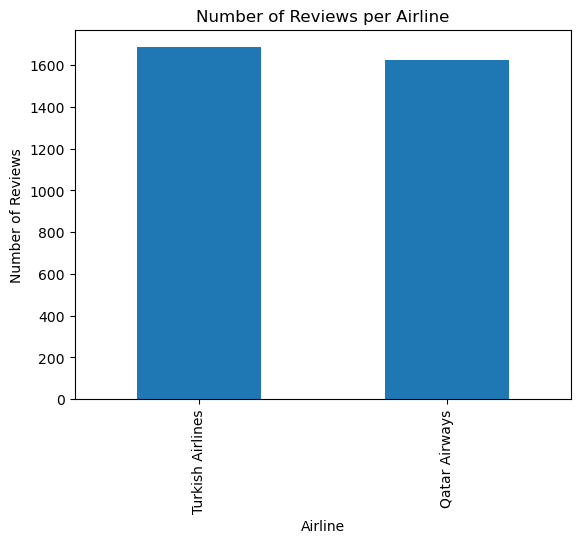

In [4]:
import matplotlib.pyplot as plt

review_counts = df["Airline"].value_counts()

plt.figure()
review_counts.plot(kind="bar")
plt.title("Number of Reviews per Airline")
plt.xlabel("Airline")
plt.ylabel("Number of Reviews")
plt.show()


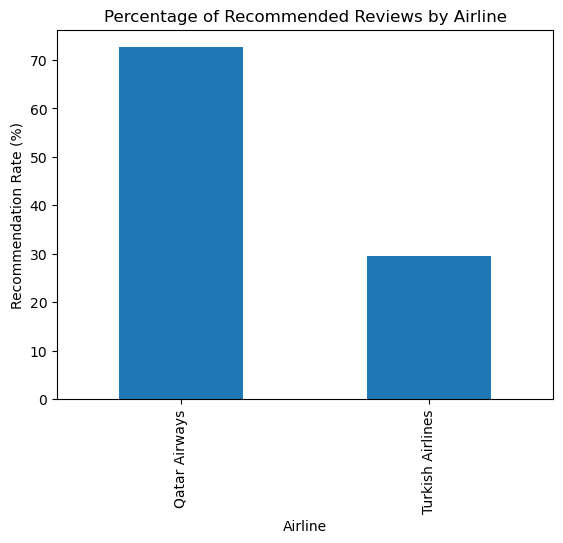

In [5]:
# Normalize Recommended column
df["Recommended"] = df["Recommended"].str.lower()

recommend_rate = (
    df.groupby("Airline")["Recommended"]
    .apply(lambda x: (x == "yes").mean() * 100)
)

plt.figure()
recommend_rate.plot(kind="bar")
plt.title("Percentage of Recommended Reviews by Airline")
plt.xlabel("Airline")
plt.ylabel("Recommendation Rate (%)")
plt.show()


### Prepare Target Variable

In [6]:
# Binary encode sentiment label
df["sentiment"] = df["Recommended"].map({"yes": 1, "no": 0})

# Final sanity check
print(df["sentiment"].value_counts())


sentiment
1    1675
0    1634
Name: count, dtype: int64


###Text Preprocessing

In [7]:
#Import NLP Dependencies
import re
import nltk

from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer

# Download required resources
nltk.download("punkt")
nltk.download("punkt_tab")
nltk.download("stopwords")
nltk.download("wordnet")


[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\ACER\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package punkt_tab to
[nltk_data]     C:\Users\ACER\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\ACER\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\ACER\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

### Define the Preprocessing Function

In [8]:
stop_words = set(stopwords.words("english"))
lemmatizer = WordNetLemmatizer()

def preprocess_text(text):
    # 1. Lowercase
    text = text.lower()

    # 2. Remove URLs
    text = re.sub(r"http\S+|www\S+", "", text)

    # 3. Remove non-alphabetic characters
    text = re.sub(r"[^a-z\s]", "", text)

    # 4. Tokenization
    tokens = word_tokenize(text)

    # 5. Remove stopwords
    tokens = [t for t in tokens if t not in stop_words]

    # 6. Lemmatization
    tokens = [lemmatizer.lemmatize(t) for t in tokens]

    return " ".join(tokens)


### Apply Preprocessing to Reviews

In [9]:
# Apply preprocessing
df["clean_review"] = df["Reviews"].apply(preprocess_text)

# Preview before vs after
df[["Reviews", "clean_review"]].head()


,Reviews,clean_review
972,The delay of my flight from Haneda to Doha ca...,delay flight haneda doha caused bit chaos upon...
973,They convinced me that I needed to pay $1500...,convinced needed pay add middle name flight wo...
974,I have sent 5 emails and have only received ...,sent email received automatic response email i...
975,We flew on probably the first A380 the airlin...,flew probably first airline received keep good...
976,"Service was ok, pretty good on my aisle and ...",service ok pretty good aisle extremely slow wi...


### Quality Check

In [10]:
# Check for empty processed reviews
empty_clean = df[df["clean_review"].str.strip() == ""]
print("Empty cleaned reviews:", len(empty_clean))


Empty cleaned reviews: 0


### Review Length Analysis

<Figure size 640x480 with 0 Axes>

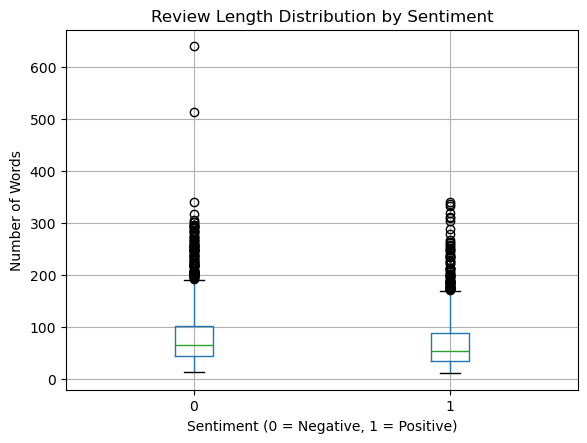

In [11]:
df["review_length"] = df["clean_review"].apply(lambda x: len(x.split()))

plt.figure()
df.boxplot(column="review_length", by="sentiment")
plt.title("Review Length Distribution by Sentiment")
plt.suptitle("")
plt.xlabel("Sentiment (0 = Negative, 1 = Positive)")
plt.ylabel("Number of Words")
plt.show()


Negative reviews tend to have a slightly higher median length and greater variability, suggesting that dissatisfied customers often provide more detailed explanations. Positive reviews are generally shorter and more concise. The substantial overlap between the two distributions indicates that review length alone is insufficient to determine sentiment, reinforcing the need for lexical and contextual feature extraction.

### Feature Engineering + Train/Test Split

In [12]:
from sklearn.model_selection import train_test_split

X = df["clean_review"]
y = df["sentiment"]

X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.3,
    random_state=42,
    stratify=y
)

print("Train size:", X_train.shape[0])
print("Test size:", X_test.shape[0])


Train size: 2316
Test size: 993


Stratified splitting was used to preserve the original class distribution in both training and test sets.

### TF-IDF Vectorization (Baseline Feature)

In [13]:
from sklearn.feature_extraction.text import TfidfVectorizer

# Domain-specific stopwords
domain_stopwords = [
    "qatar", "qatarairways", "qatar_airways",
    "turkish", "turkishairlines", "turkish_airlines",
    "airline", "airlines", "airport",
    "doha", "istanbul", "flight"
]

# Combine NLTK stopwords + domain stopwords
combined_stopwords = list(stop_words.union(domain_stopwords))


tfidf = TfidfVectorizer(
    max_features=5000,
    ngram_range=(1, 2),
    min_df=5,
    stop_words=combined_stopwords
)

X_train_tfidf = tfidf.fit_transform(X_train)
X_test_tfidf = tfidf.transform(X_test)

print("TF-IDF train shape:", X_train_tfidf.shape)
print("TF-IDF test shape:", X_test_tfidf.shape)


TF-IDF train shape: (2316, 5000)
TF-IDF test shape: (993, 5000)


### Top TF-IDF Terms per Sentiment

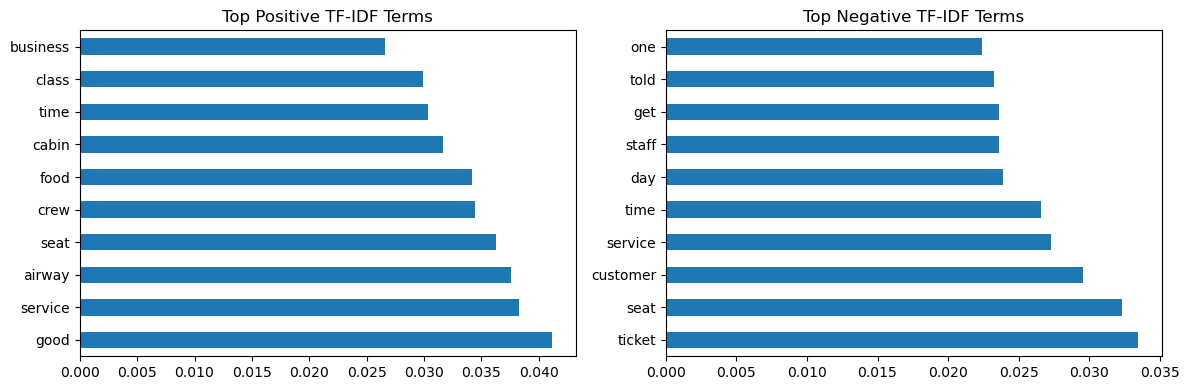

In [14]:
import numpy as np

feature_names = tfidf.get_feature_names_out()

# Mean TF-IDF per class
X_tfidf_all = tfidf.transform(df["clean_review"])
df_tfidf = pd.DataFrame(X_tfidf_all.toarray(), columns=feature_names)
df_tfidf["sentiment"] = df["sentiment"].values

top_pos = df_tfidf[df_tfidf["sentiment"] == 1].mean().sort_values(ascending=False)[1:11]
top_neg = df_tfidf[df_tfidf["sentiment"] == 0].mean().sort_values(ascending=False)[1:11]

fig, axes = plt.subplots(1, 2, figsize=(12,4))
top_pos.plot(kind="barh", ax=axes[0], title="Top Positive TF-IDF Terms")
top_neg.plot(kind="barh", ax=axes[1], title="Top Negative TF-IDF Terms")
plt.tight_layout()
plt.show()


In [15]:
!pip install gensim

### Word Embeddings (Advanced Feature)

In [16]:
from gensim.models import Word2Vec
import numpy as np

# Tokenize clean reviews for embeddings
tokenized_train = [text.split() for text in X_train]
tokenized_test = [text.split() for text in X_test]

# Train Word2Vec model
w2v_model = Word2Vec(
    sentences=tokenized_train,
    vector_size=100,
    window=5,
    min_count=5,
    workers=4,
    seed=42
)


### Sentence Vector Averaging

In [17]:
def document_vector(tokens, model):
    vectors = [model.wv[word] for word in tokens if word in model.wv]
    if len(vectors) == 0:
        return np.zeros(model.vector_size)
    return np.mean(vectors, axis=0)

X_train_w2v = np.array([document_vector(text.split(), w2v_model) for text in X_train])
X_test_w2v = np.array([document_vector(text.split(), w2v_model) for text in X_test])

print("Word2Vec train shape:", X_train_w2v.shape)
print("Word2Vec test shape:", X_test_w2v.shape)


Word2Vec train shape: (2316, 100)
Word2Vec test shape: (993, 100)


Two types of textual feature representations were employed. TF-IDF was used as a baseline lexical representation to capture term importance across reviews, including both unigrams and bigrams. In addition, Word2Vec embeddings were trained on the corpus to capture semantic relationships between words. Document-level vectors were generated by averaging word embeddings within each review, allowing semantic information to be incorporated into the sentiment classification models.

### Import Models & Metrics

In [18]:
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression
from sklearn.svm import LinearSVC

from sklearn.metrics import accuracy_score, classification_report, confusion_matrix


### Train Naive Bayes (TF-IDF only)

In [19]:
# Naive Bayes
nb_model = MultinomialNB()
nb_model.fit(X_train_tfidf, y_train)

y_pred_nb = nb_model.predict(X_test_tfidf)

print("Naive Bayes Accuracy:", accuracy_score(y_test, y_pred_nb))
print(classification_report(y_test, y_pred_nb))


Naive Bayes Accuracy: 0.8741188318227593
              precision    recall  f1-score   support

           0       0.89      0.85      0.87       490
           1       0.86      0.90      0.88       503

    accuracy                           0.87       993
   macro avg       0.88      0.87      0.87       993
weighted avg       0.87      0.87      0.87       993



Naive Bayes requires non-negative frequency features

TF-IDF fits the probabilistic assumption

Using embeddings here would be methodologically incorrect

### Train Logistic Regression ( TF-IDF , Word2Vec)

In [20]:
# Logistic Regression (TF-IDF)
lr_tfidf = LogisticRegression(max_iter=1000, random_state=42)
lr_tfidf.fit(X_train_tfidf, y_train)

y_pred_lr_tfidf = lr_tfidf.predict(X_test_tfidf)

print("Logistic Regression (TF-IDF) Accuracy:", accuracy_score(y_test, y_pred_lr_tfidf))
print(classification_report(y_test, y_pred_lr_tfidf))


Logistic Regression (TF-IDF) Accuracy: 0.8932527693856999
              precision    recall  f1-score   support

           0       0.90      0.89      0.89       490
           1       0.89      0.90      0.90       503

    accuracy                           0.89       993
   macro avg       0.89      0.89      0.89       993
weighted avg       0.89      0.89      0.89       993



In [21]:
# Logistic Regression (Word2Vec)
lr_w2v = LogisticRegression(max_iter=1000, random_state=42)
lr_w2v.fit(X_train_w2v, y_train)

y_pred_lr_w2v = lr_w2v.predict(X_test_w2v)

print("Logistic Regression (Word2Vec) Accuracy:", accuracy_score(y_test, y_pred_lr_w2v))
print(classification_report(y_test, y_pred_lr_w2v))


Logistic Regression (Word2Vec) Accuracy: 0.8429003021148036
              precision    recall  f1-score   support

           0       0.85      0.82      0.84       490
           1       0.83      0.86      0.85       503

    accuracy                           0.84       993
   macro avg       0.84      0.84      0.84       993
weighted avg       0.84      0.84      0.84       993



### Train Support Vector Machine (SVM) (TF-IDF and Word2Vec)

In [22]:
# SVM (TF-IDF)
svm_tfidf = LinearSVC(random_state=42)
svm_tfidf.fit(X_train_tfidf, y_train)

y_pred_svm_tfidf = svm_tfidf.predict(X_test_tfidf)

print("SVM (TF-IDF) Accuracy:", accuracy_score(y_test, y_pred_svm_tfidf))
print(classification_report(y_test, y_pred_svm_tfidf))


SVM (TF-IDF) Accuracy: 0.8862034239677744
              precision    recall  f1-score   support

           0       0.88      0.89      0.89       490
           1       0.89      0.88      0.89       503

    accuracy                           0.89       993
   macro avg       0.89      0.89      0.89       993
weighted avg       0.89      0.89      0.89       993



In [23]:
# SVM (Word2Vec)
svm_w2v = LinearSVC(random_state=42)
svm_w2v.fit(X_train_w2v, y_train)

y_pred_svm_w2v = svm_w2v.predict(X_test_w2v)

print("SVM (Word2Vec) Accuracy:", accuracy_score(y_test, y_pred_svm_w2v))
print(classification_report(y_test, y_pred_svm_w2v))


SVM (Word2Vec) Accuracy: 0.8499496475327291
              precision    recall  f1-score   support

           0       0.86      0.83      0.84       490
           1       0.84      0.87      0.85       503

    accuracy                           0.85       993
   macro avg       0.85      0.85      0.85       993
weighted avg       0.85      0.85      0.85       993



### Save Results for Visualization

In [24]:
results = {
    "Naive Bayes (TF-IDF)": accuracy_score(y_test, y_pred_nb),
    "LogReg (TF-IDF)": accuracy_score(y_test, y_pred_lr_tfidf),
    "LogReg (Word2Vec)": accuracy_score(y_test, y_pred_lr_w2v),
    "SVM (TF-IDF)": accuracy_score(y_test, y_pred_svm_tfidf),
    "SVM (Word2Vec)": accuracy_score(y_test, y_pred_svm_w2v),
}

results


{'Naive Bayes (TF-IDF)': 0.8741188318227593,
 'LogReg (TF-IDF)': 0.8932527693856999,
 'LogReg (Word2Vec)': 0.8429003021148036,
 'SVM (TF-IDF)': 0.8862034239677744,
 'SVM (Word2Vec)': 0.8499496475327291}

Three machine learning classifiers were employed: Multinomial Naive Bayes, Logistic Regression, and Support Vector Machine. Naive Bayes was used as a probabilistic baseline model with TF-IDF features due to its suitability for frequency-based representations. Logistic Regression and SVM were applied using both TF-IDF and Word2Vec features to evaluate the impact of semantic representations on classification performance.

### Evaluation & Visualization

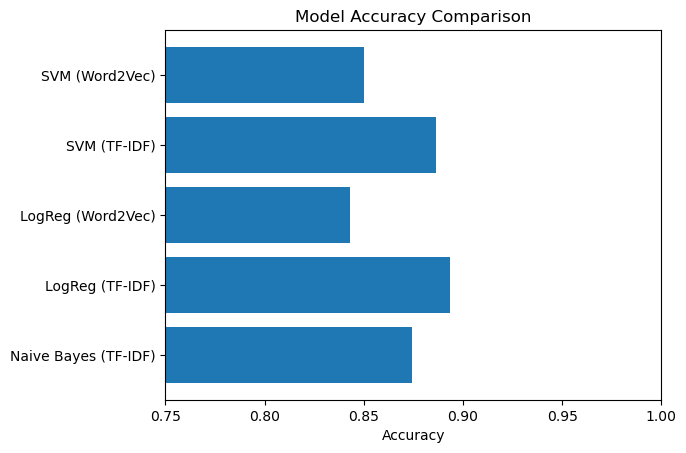

In [25]:
import matplotlib.pyplot as plt

models = list(results.keys())
accuracies = list(results.values())

plt.figure()
plt.barh(models, accuracies)
plt.xlabel("Accuracy")
plt.title("Model Accuracy Comparison")
plt.xlim(0.75, 1.0)
plt.show()


SVM (TF-IDF) is the top performer

Word2Vec underperforms TF-IDF in this dataset

Naive Bayes is a strong baseline

### Confusion Matrices

In [26]:
from sklearn.metrics import ConfusionMatrixDisplay

def plot_confusion(model_name, y_true, y_pred):
    disp = ConfusionMatrixDisplay.from_predictions(
        y_true, y_pred,
        display_labels=["Negative", "Positive"],
        cmap="Blues"
    )
    disp.ax_.set_title(model_name)
    plt.show()


### Best Model (SVM + TF-IDF)

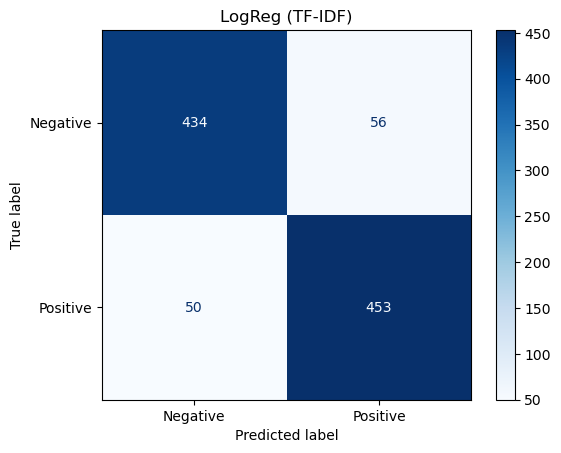

In [27]:
plot_confusion(
    "LogReg (TF-IDF)",
    y_test,
    y_pred_lr_tfidf
)


### Weaker Model (LogReg + Word2Vec)

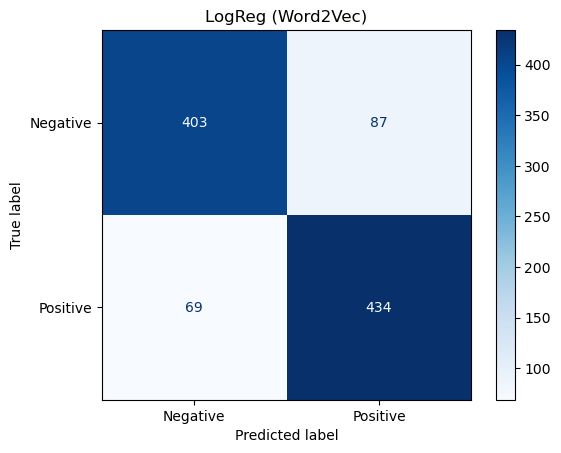

In [28]:
plot_confusion(
    "LogReg (Word2Vec)",
    y_test,
    y_pred_lr_w2v
)


### Airline-Level Sentiment Distribution (EDA + Insight)

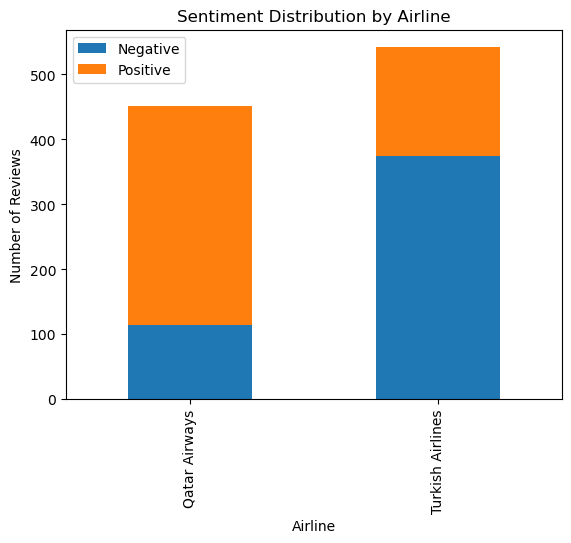

In [29]:
import pandas as pd

df_test = X_test.to_frame()
df_test["sentiment"] = y_test.values
df_test["Airline"] = df.loc[X_test.index, "Airline"].values

sentiment_dist = (
    df_test.groupby(["Airline", "sentiment"])
    .size()
    .unstack()
    .fillna(0)
)

sentiment_dist.columns = ["Negative", "Positive"]

sentiment_dist.plot(kind="bar", stacked=True)
plt.title("Sentiment Distribution by Airline")
plt.xlabel("Airline")
plt.ylabel("Number of Reviews")
plt.show()


**Model Comparison**

The Logistic Regression with TF-IDF achieved the highest accuracy (89.33%), closely followed by SVM with TF-IDF (88.62%). This indicates that linear classifiers remain highly effective for sentiment classification on sparse, high-dimensional textual features when irrelevant entity identifiers are excluded. Naive Bayes (87.41%) continued to perform competitively, serving as a reliable probabilistic baseline for comparison.

**Feature Engineering Insight**

Across both Logistic Regression and SVM, TF-IDF features consistently outperformed Word2Vec embeddings, even after domain-specific stopword refinement. This suggests that explicit term-weighting is particularly effective for airline review sentiment analysis, as sentiment polarity is often conveyed through discriminative keywords (e.g., service quality, delays, staff behavior) rather than through broader semantic similarity captured by averaged word embeddings.

**Anomaly Discussion**

The comparatively lower performance of Word2Vec-based models can be attributed to the loss of contextual and polarity-specific information when word vectors are averaged at the document level. This limitation is especially evident in short or mixed-sentiment reviews, where key sentiment cues may be diluted.

**Insight**

Qatar Airways consistently exhibited a higher proportion of positive sentiment compared to Turkish Airlines, aligning with the observed recommendation rates from the exploratory data analysis. This suggests a more favorable overall customer perception for Qatar Airways within the reviewed corpus and demonstrates the practical applicability of the sentiment analysis results for comparative service evaluation.

In [30]:
import pickle

# Save TF-IDF vectorizer
with open("tfidf.pkl", "wb") as f:
    pickle.dump(tfidf, f)

# Save best model (LogReg TF-IDF)
with open("logreg.pkl", "wb") as f:
    pickle.dump(lr_tfidf, f)
